## Visualizing Filters of a Convolutional Neural Network

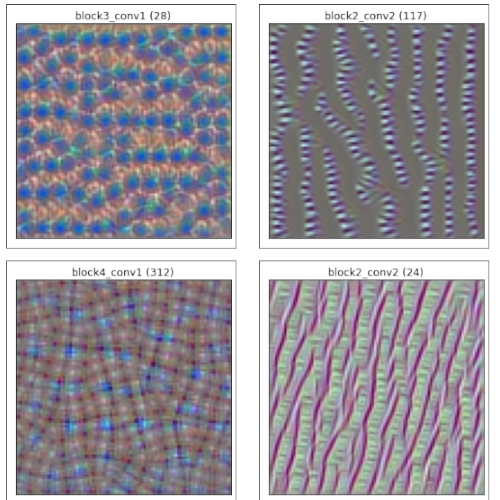

## Task 2: Downloading the Model

In [1]:
import tensorflow as tf
import random
import matplotlib.pyplot as plt

print('Tensorflow version', tf.__version__)

Tensorflow version 2.11.0


In [2]:
#Final fully connected layers are not included since no classification is being done here 
#Weights trained on iimagenet dataset 
model = tf.keras.applications.vgg16.VGG16(
    include_top = False, weights = 'imagenet', 
    input_shape = (96,96,3)
)
model.summary()

# In block 1 and 2, relatively simple features are being learnt. From 3rd block, more complicated features/patterns
# are learnt by the filters.

58889256/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 96, 96, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 96, 96, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 48, 48, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 48, 48, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 48, 48, 128)       147584    
                                                              

## Task 3: Get Layer Output

In [3]:
#Sub model to view specific filters from a layer, say block3_conv2 which will give the 
#This will give output from input till the particular layer we want to look at and not the entire model 
def get_submodel(layer_name):
  return tf.keras.models.Model(
      model.input,
      model.get_layer(layer_name).output
  )

get_submodel('block1_conv2').summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 96, 96, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 96, 96, 64)        36928     
                                                                 
Total params: 38,720
Trainable params: 38,720
Non-trainable params: 0
_________________________________________________________________


## Task 4: Image Visualization

In [4]:
#Random images as input(noise)
def create_image():
  return tf.random.uniform((96,96,3), minval = -0.5, maxval = 0.5)

def plot_image(image, title = 'random'):
  image = image - tf.math.reduce_min(image)
  image = image / tf.math.reduce_max(image)
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])
  plt.title(title)
  plt.show()

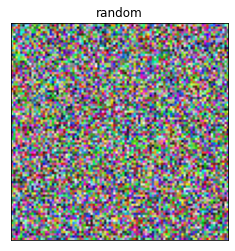

In [5]:
image = create_image()
plot_image(image)

## Task 5: Training Loop

In [6]:
#It's not really visualizing the filter, it will show us the input that will maximally activate that filter, essentially
# giving us an insight into what that specific filter is really looking for in images
def visualize_filter(layer_name, f_index = None, iters = 50):
  submodel = get_submodel(layer_name)
  num_filters = submodel.output.shape[-1]   #Number of filters that submodel has in the output, last item of this shape
  print(num_filters)
  if f_index is None:
    f_index = random.randint(0, num_filters - 1)
  assert num_filters > f_index, 'f_index is out of bounds'
  print(f_index)
  image = create_image() #Generating input image
  verbose_step = int(iters / 10)
  
  #Algorithm for gradient ascent - we are trying to maximize the so called loss value, which is the output of the submodel at
  #at that particular filter

  for i in range(0,iters):
    with tf.GradientTape() as tape:
      tape.watch(image)
      out = submodel(tf.expand_dims(image, axis = 0))[:,:,:,f_index]
      loss = tf.math.reduce_mean(out)
    grads = tape.gradient(loss, image)
    grade = tf.math.l2_normalize(grads)
    image += grads * 10

    if (i + 1) % verbose_step == 0:
      print(f'Iteration: { i + 1}, Loss: {loss.numpy():.4f}')

  plot_image(image, f'{layer_name}, {f_index}')  


## Task 6: Final Results

In [7]:
print([layer.name for layer in model.layers if 'conv' in layer.name])

['block1_conv1', 'block1_conv2', 'block2_conv1', 'block2_conv2', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block5_conv1', 'block5_conv2', 'block5_conv3']


64
40
Iteration: 40, Loss: 0.1663
Iteration: 80, Loss: 0.2245
Iteration: 120, Loss: 0.2904
Iteration: 160, Loss: 0.3616
Iteration: 200, Loss: 0.4365
Iteration: 240, Loss: 0.5143
Iteration: 280, Loss: 0.5936
Iteration: 320, Loss: 0.6739
Iteration: 360, Loss: 0.7549
Iteration: 400, Loss: 0.8361


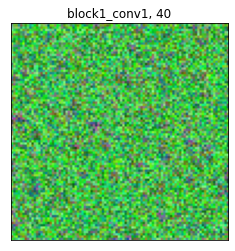

In [11]:
layer_name = 'block1_conv1' #@param ['block1_conv1', 'block1_conv2', 'block2_conv1', 'block2_conv2', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block5_conv1', 'block5_conv2', 'block5_conv3']

visualize_filter(layer_name, iters = 400)